# Prueba 2 Machine Learning

## Analizado los crímenes en la Ciudad de Nueva York

Nombre: __Hugo Andrés Zúñiga Soto__

Profesor: Josué Fredes

Generación: __G4__

__Agradecimientos:__ Verónica Martinez y Alejandra Aravena por la colaboración durante el desarrollo.
___

## Preliminares

### Descripción del problema

Se presentan datos públicos del departamento de policía de New York, donde se presenta información sobre interrogaciones y detenciones realizadas por el departamento de policia de NY en la vía pública.

### Objetivos

El objetivo es poder predecir según las características medidas del sospechoso si un determinado procedimiento concluirá o no en un arresto. Además, se requiere poder determinar si el procedimiento policial concluirá en alguna acción violenta.

### Criterios de optimización

Para analizar la información se realizará lo siguiente:
* Normalizar la cantidad de atributos

Para la búsqueda de los mejores parámetros en cada modelo, se utilizó la siguente lógica:

* Valores por defecto:
* Distancia entre los valores de cada hiperparámetro
* Iterar con valores cercanos al mejor hipermarámetro

### Métricas de desempeño

Dado que trabajaremos con modelos de clasificación utilizaremos Matriz de Confusión, ROC Curve, Precision, Recall y F1.

## Aspectos computacionales

### Módulos a implementar

Para resolver este problema se utilizarán las siguientes librerias:

In [1]:
# importo las librerias base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# importo librerias necesarias
import helpers as h
import preproc_nyc_sqf as prep
import missingno as msng
from sklearn.preprocessing import LabelBinarizer
import pickle
import re
#from sklearn.pipeline import Pipeline

# librerias para el entrenamiento
from sklearn.model_selection import train_test_split, GridSearchCV

# librerias de los clasificadores
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# para medir métricas de desempeño
from sklearn.metrics import confusion_matrix, classification_report

#fijo la semilla pseudoaleatoria
rand_seed = 16254

# evito warning
import warnings
warnings.simplefilter('ignore')

### Funciones generadas

Para el preprocesamiento, refinación y representación de los datos utilizaremos distintas funciones que nos permitirán reducir el espacio de exploración.

Las funciones implementadas serán:

* Refactorización variables categóricas
* Refinamiento de texto
* Descripción de atrinuto
* Inspeción vector objetivo

## Análisis Exploratorio

### Importación y preparación de datos

In [2]:
# importo los datos de entrenamiento
train_df = pd.read_csv('files/2009_1perc.csv').drop(columns='Unnamed: 0')
train_df.sample(5)

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
2612  2009  123      601   3162009      1455       A     O       P     5.0   
2820  2009   52     8221  11112009      2300       A     O       P     1.0   
522   2009  120     4934   3152009        30       A     O       P     1.0   
3116  2009   22      337   6252009      1350       A     O       P    10.0   
171   2009  105     3666   5082009      1330       A     O       P     1.0   

      crimsusp  ...  zip addrpct sector beat post   xcoord   ycoord dettypcm  \
2612       CPW  ...          123      D            0927270  0134804       CM   
2820       CPW  ...           52      C            1011117  0253835       CM   
522   BURGLARY  ...          120      P            0946627  0170580       CM   
3116   ROBBERY  ...           22      E   14                              CM   
171     FELONY  ...          105      H   16       1055830  0192838       CM   

      linecm  detailcm  
2612       1        20  
2820       1        20  
522        1        14  
3116       1        85  
171        1        85  

[5 rows x 111 columns]

In [3]:
# importo los datos de test
test_df = pd.read_csv('files/2010_1perc.csv').drop(columns='Unnamed: 0')
test_df.sample(5)

year  pct  ser_num  datestop  timestop recstat inout trhsloc  perobs  \
14    2010  102     6089   8092010      2150       A     O       P       1   
1892  2010    9      190   1152010      1315       A     O       P       1   
883   2010   70     1213   2172010      1631       A     I       P       1   
5500  2010  106     4745   8082010      1350       A     O       P       1   
5471  2010   71     1073   2202010      1910       A     O       P       1   

          crimsusp  ...  zip addrpct sector beat  post   xcoord  ycoord  \
14    CRIMINAL MIS  ...          102      D             1024980  189577   
1892        FELONY  ...            9      E    7         986926  203388   
883     CRIM TRESS  ...           70      J   24         994935  177065   
5500           FEL  ...          106      I         11  1038636  185108   
5471           GLA  ...           71      B    2         997512  182378   

     dettypcm  linecm  detailcm  
14         CM       1        23  
1892       CM       1        45  
883        CM       1        31  
5500       CM       1        20  
5471       CM       1        46  

[5 rows x 111 columns]

In [4]:
# Revisamos el volumen de datos de cada dataset
print(train_df.shape, test_df.shape)

(5812, 111) (6013, 111)


In [5]:
# Se debe refactorizar dada la gran cantidad de atributos, para ello se utiliza la función 
# create_suitable_dataframe_v2 data en preproc_nyc_sqf.py
train_df_st, train_attr = prep.create_suitable_dataframe_v2(train_df)
test_df_st, test_attr = prep.create_suitable_dataframe_v2(test_df, train_attr)
# comparamos la cantidad de atributos de ambos datasets
print(train_df_st.shape, test_df_st.shape)

(4636, 74) (4747, 74)


In [6]:
# Unimos los datos de entrenamiento y validación para realizar el análisis exploratorio
total_df = pd.concat([train_df_st, test_df_st])

In [7]:
# analizo los datos de entrenamiento
total_df.sample(5)

recstat inout trhsloc typeofid explnstp othpers arstmade sumissue  \
4235       A     O       P        V        Y       N        N        N   
2970       A     O       P        V        Y       N        N        N   
5297       A     O       U        P        Y       Y        N        N   
385        A     O       P        V        Y       Y        N        N   
1822       1     I       H        V        Y       N        N        N   

     offunif officrid  ... race haircolr eyecolor build           city sector  \
4235       Y        N  ...    W       BR       BR     M         QUEENS      I   
2970       Y        N  ...    B       BK       BK     T       BROOKLYN      A   
5297       Y        N  ...    Q       BK       BR     M       BROOKLYN      A   
385        Y        N  ...    W       BR       BR     M  STATEN ISLAND      U   
1822       Y        N  ...    Q       BK       BR     M       BROOKLYN      G   

     beat post     month   meters  
4235    U    U     APRIL  1.55448  
2970    2    U      JUNE  1.79832  
5297    U    U   OCTOBER  1.70688  
385     U    U    AUGUST  1.73736  
1822    U    U  NOVEMBER  1.79832  

[5 rows x 74 columns]

In [8]:
# reviso los tipos de datos
total_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9383 entries, 0 to 6012
Data columns (total 74 columns):
recstat     9383 non-null object
inout       9383 non-null object
trhsloc     9383 non-null object
typeofid    9383 non-null object
explnstp    9383 non-null object
othpers     9383 non-null object
arstmade    9383 non-null object
sumissue    9383 non-null object
offunif     9383 non-null object
officrid    9383 non-null object
frisked     9383 non-null object
searched    9383 non-null object
contrabn    9383 non-null object
pistol      9383 non-null object
riflshot    9383 non-null object
asltweap    9383 non-null object
knifcuti    9383 non-null object
othrweap    9383 non-null object
pf_hands    9383 non-null object
pf_wall     9383 non-null object
pf_grnd     9383 non-null object
pf_drwep    9383 non-null object
pf_ptwep    9383 non-null object
pf_baton    9383 non-null object
pf_hcuff    9383 non-null object
pf_pepsp    9383 non-null object
pf_other    9383 non-null object
ra

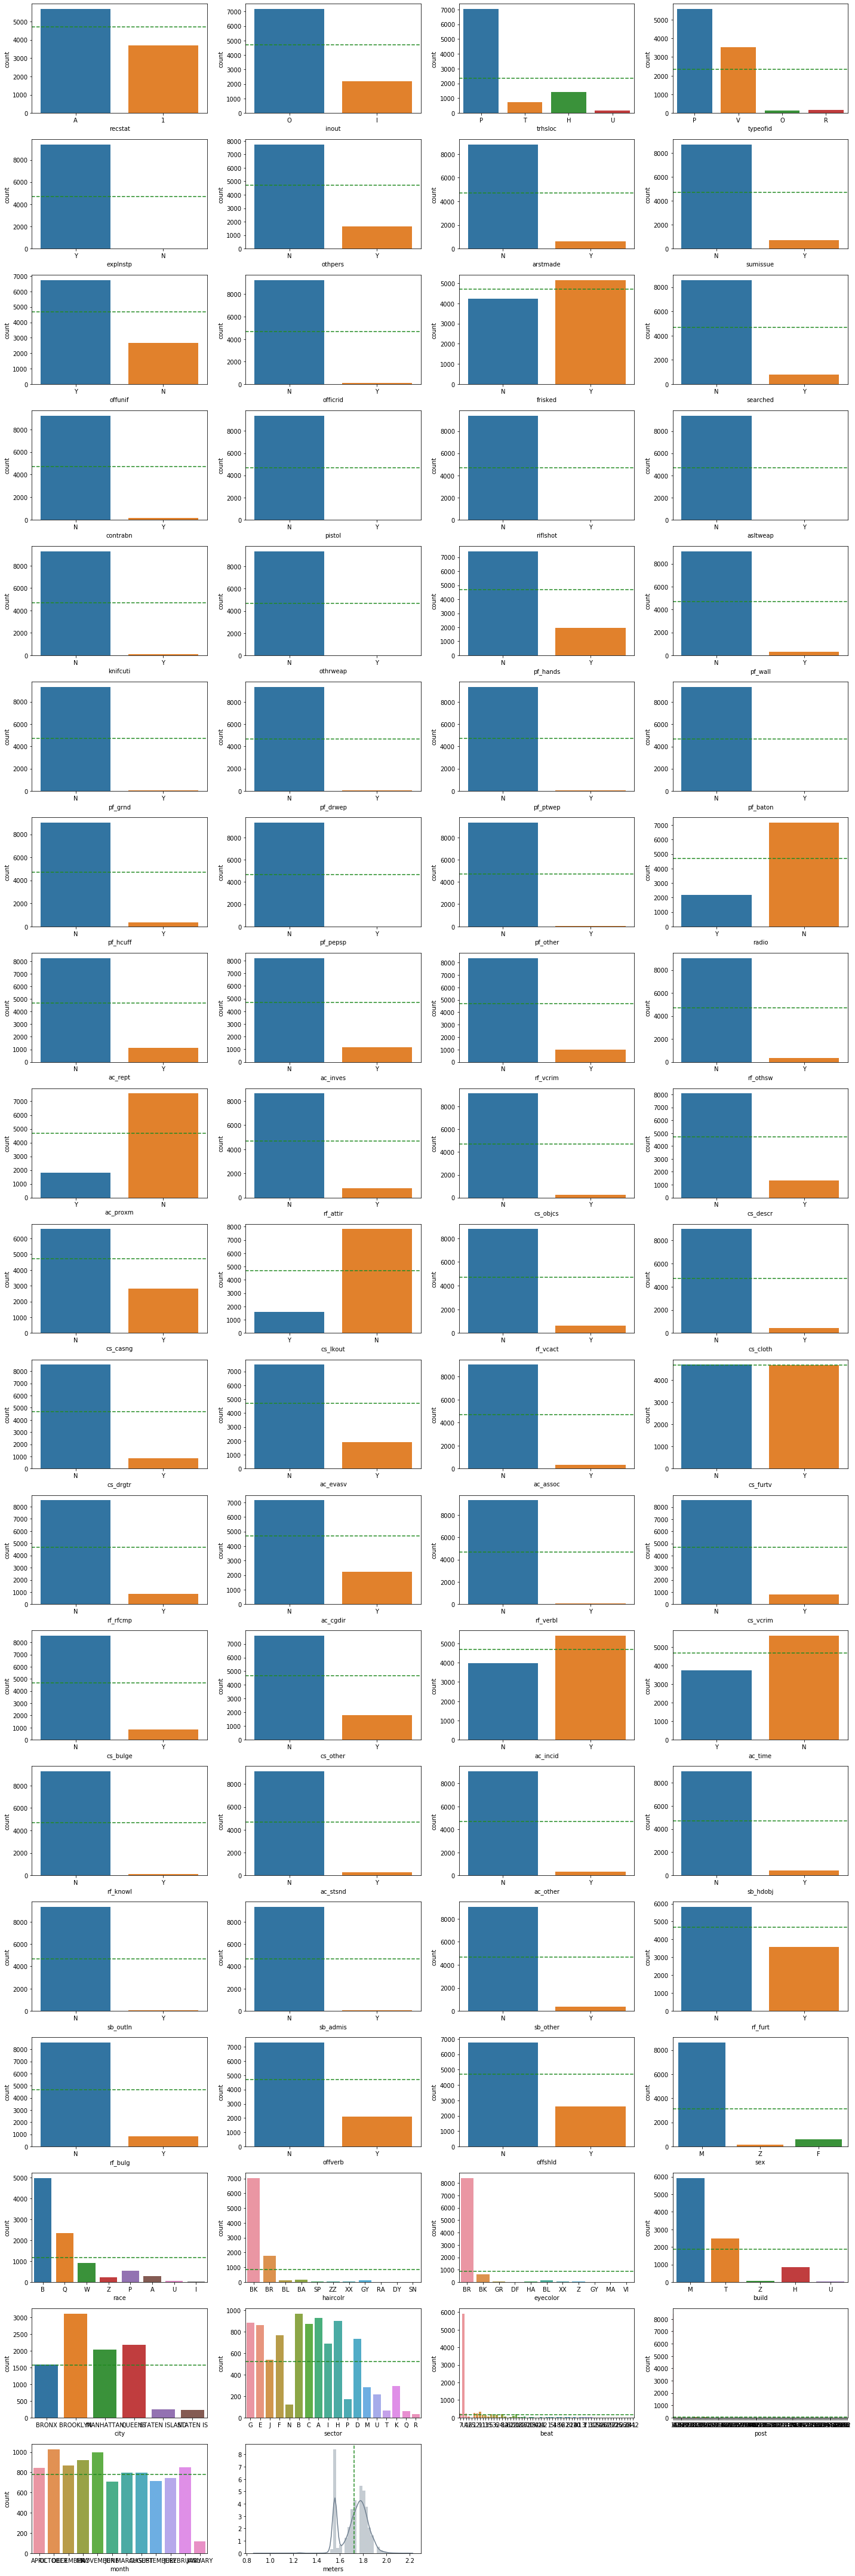

In [9]:
prep.graph_df(total_df)

In [10]:
# revisamos beat
total_df['beat'].value_counts('%')

U       0.631035
9       0.034957
1       0.027497
7       0.025791
4       0.023447
          ...   
30      0.000107
26      0.000107
32      0.000107
  25    0.000107
  42    0.000107
Name: beat, Length: 63, dtype: float64

In [11]:
# revisamos post
total_df['post'].value_counts('%')

U       0.899286
8       0.004156
16      0.003517
10      0.003410
14      0.003197
          ...   
  57    0.000107
  78    0.000107
  68    0.000107
  48    0.000107
  35    0.000107
Name: post, Length: 149, dtype: float64

__Comentarios:__ Revisando los atributos categóricos podemos ver que algunos presentan alto sesgo, considerando además que el valor más representativo corresponde a un valor perdido y que presenta un numero alto de clases. Dado esto, no consideraremos para este análisis los siguientes atributos:

* `beat`: LOCATION OF STOP BEAT
* `post`: LOCATION OF STOP POST

In [12]:
# redefinimos el data set sin estas variables
total_df = train_df_st.drop(columns=['beat','post'])

In [13]:
# revisamos una muestra
total_df.sample(5)

recstat inout trhsloc typeofid explnstp othpers arstmade sumissue  \
3453       A     I       P        P        Y       N        N        Y   
5210       1     I       T        V        Y       Y        N        N   
966        1     O       P        V        Y       N        N        N   
5624       1     O       P        V        Y       N        N        N   
2168       1     O       H        P        Y       N        Y        N   

     offunif officrid  ... offshld sex race haircolr eyecolor build  \
3453       Y        N  ...       N   M    Q       BK       BR     M   
5210       N        N  ...       Y   M    B       BK       BR     M   
966        Y        N  ...       N   M    B       BK       BR     T   
5624       N        N  ...       Y   M    B       BK       BR     M   
2168       Y        N  ...       N   M    B       BK       BR     T   

           city sector     month    meters  
3453   BROOKLYN      G  FEBRUARY  1.554480  
5210  MANHATTAN      A  DECEMBER  1.767840  
966       BRONX      I  FEBRUARY  1.557528  
5624     QUEENS      I  DECEMBER  1.554480  
2168  MANHATTAN      B    AUGUST  1.615440  

[5 rows x 72 columns]

In [14]:
# quitamos a la lista de atributos los que no analizaremos
train_attr_rd = train_attr.copy()
train_attr_rd.remove('beat')
train_attr_rd.remove('post')

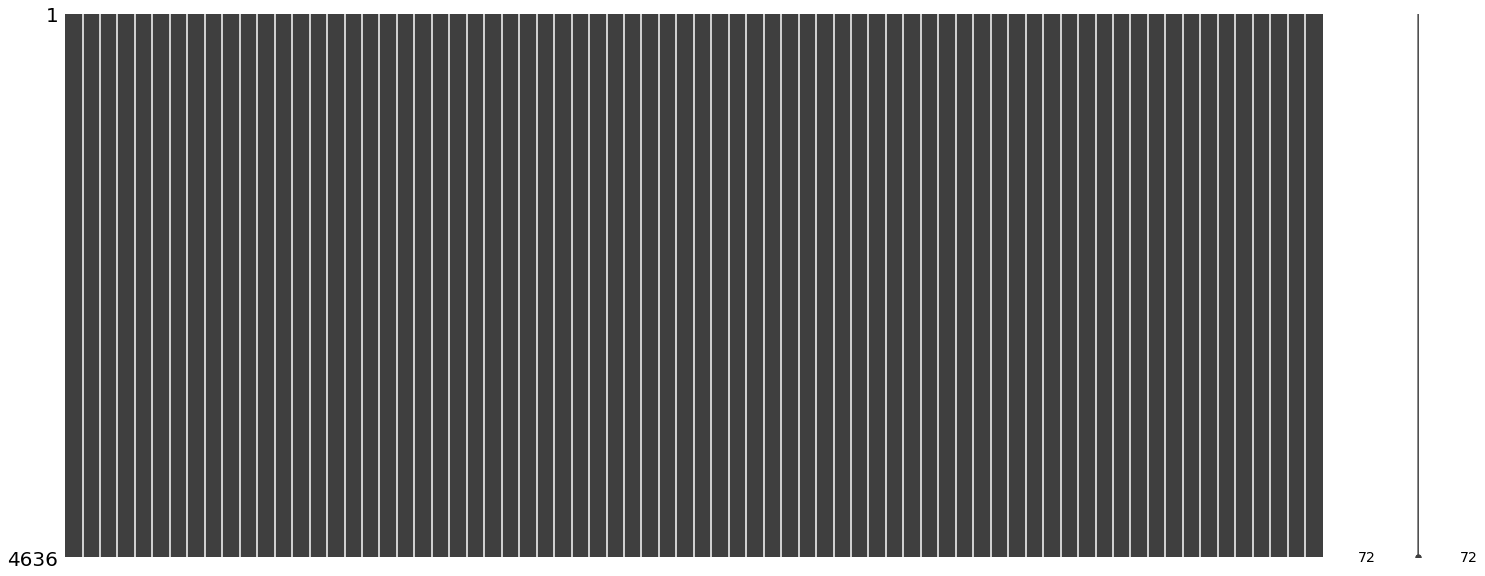

In [15]:
# verificamos datos perdidos
msng.matrix(total_df)

N    0.939387
Y    0.060613
Name: arstmade, dtype: float64


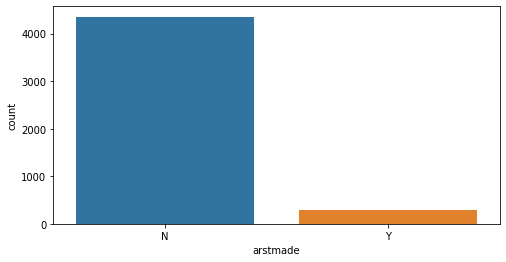

In [16]:
# analizamos el vector objetivo para un arresto
plt.figure(figsize=(8,4))
print(total_df['arstmade'].value_counts('%'))
sns.countplot(total_df['arstmade'])

__Comentario:__ Podemos ver que del total de detenciones, un 6% terminan en un arresto.

## Feature Engineering

__Comentario__: Ya que deberemos tratar los datos de entrenamiento y prueba, no podemos binarizar las variables con `getdummies()`. Esto provocaría errores en la genración de variables. Por esto, consideraremos utilizar `LabelBinarizer` de `sklearn.preprocessing`.

In [17]:
# genero una lista con los atributos a binarizar
train_attr_cat = train_attr_rd.copy()
# descarto la variable continua meters
train_attr_cat.remove('meters')
# reviso la cantidad de atributos a considerar
print(len(list(train_attr_cat)))

71


In [18]:
# genero un nuevo dataframe binarizado solo con el conjunto de entrenamiento
train_df_bin = pd.DataFrame(train_df_st['meters'].reset_index())
# genero una lista para guardar la codificacion de cada atributo
Encoders = []
# recorro cada atributo
for atr in train_attr_cat:
    # inicializo el codificador
    encoder = LabelBinarizer(neg_label=-1, pos_label=1)
    # genero un vector con la codificacion
    X = encoder.fit_transform(train_df_st[atr].values)
    # guardo en la lista el nombre del atributo y la codificacion 
    Encoders.append([atr, encoder])
    # guardo las nuevas columnas del atributo
    val_cols = list(encoder.classes_)
    # se generan los nuevos atributos 
    if X.shape[1] > 2:
        # si son más de dos clases, se genera un atributo por clase
        tmp_df = pd.DataFrame(X, columns = list([atr+'_'+str(i) for i in val_cols]))
    else:
        # si se tienen dos clases, se genera solo un nuevo atributo con la variable con mayor presencia
        tmp_df = pd.DataFrame(X, columns = list([atr+'_bin']))
    # concateno al nuevo df 
    train_df_bin = pd.concat([train_df_bin, tmp_df], axis=1)

In [19]:
# reviso el nuevo dataframe
train_df_bin.shape

(4636, 143)

In [20]:
train_df_bin.head()

index    meters  recstat_bin  inout_bin  trhsloc_H  trhsloc_P  trhsloc_T  \
0      0  1.798320            1          1         -1          1         -1   
1      2  1.920240           -1          1         -1          1         -1   
2      3  1.676400            1          1         -1          1         -1   
3      5  1.767840           -1         -1         -1         -1          1   
4      6  1.557528           -1          1         -1          1         -1   

   trhsloc_U  typeofid_O  typeofid_P  ...  month_DECEMBER  month_FEBRUARY  \
0         -1          -1           1  ...              -1              -1   
1         -1          -1          -1  ...              -1              -1   
2         -1          -1           1  ...               1              -1   
3         -1          -1          -1  ...              -1              -1   
4         -1          -1           1  ...              -1              -1   

   month_JANUARY  month_JULY  month_JUNE  month_MARCH  month_MAY  \
0             -1          -1          -1           -1         -1   
1             -1          -1          -1           -1         -1   
2             -1          -1          -1           -1         -1   
3             -1          -1          -1           -1          1   
4             -1          -1          -1           -1         -1   

   month_NOVEMBER  month_OCTOBER  month_SEPTEMBER  
0              -1             -1               -1  
1              -1              1               -1  
2              -1             -1               -1  
3              -1             -1               -1  
4               1             -1               -1  

[5 rows x 143 columns]

__Comentario:__ En el caso de una acción violenta se debe generar el vector objetivo considerando los siguientes atributos:
* `pf_hands`
* `pf_wall`
* `pf_grnd`
* `pf_drwep`
* `pf_ptwep`
* `pf_baton`
* `pf_hcuff`
* `pf_pepsp`
* `pf_other`

In [21]:
# genero un dataframe temporal para explorar estos atributos
tmp_df = train_df_bin.filter(regex='pf_*', axis=1)
tmp_df.sample(5)

pf_hands_bin  pf_wall_bin  pf_grnd_bin  pf_drwep_bin  pf_ptwep_bin  \
4532             1           -1           -1            -1            -1   
2180            -1           -1           -1            -1            -1   
30              -1           -1           -1            -1            -1   
1098             1           -1           -1            -1            -1   
4588            -1           -1           -1            -1            -1   

      pf_baton_bin  pf_hcuff_bin  pf_pepsp_bin  pf_other_bin  
4532            -1            -1            -1            -1  
2180            -1            -1            -1            -1  
30              -1             1            -1            -1  
1098            -1            -1            -1            -1  
4588            -1            -1            -1            -1

__Comentario:__ Para generar el vector objetivo debemos considerar que al menos una de las acciones anteriores sea igual a `1`, de esta manera una acción violenta se genera de la siguiente manera:

In [22]:
# genero un nuevo atributo donde almaceno la suma de los atributos anteriores
train_df_bin['act_violenta_bin'] = train_df_bin[['pf_hands_bin','pf_wall_bin','pf_grnd_bin','pf_drwep_bin','pf_ptwep_bin','pf_baton_bin','pf_hcuff_bin','pf_pepsp_bin','pf_other_bin']].sum(axis=1)
# dado que son 9 atributos, en el caso que la suma sea mayor a -9 (es negativo dado que las clases son 1 y -1)
# estamos en presencia de una acción violenta y se deja en 1, de lo contrario -1
train_df_bin['act_violenta_bin'] = np.where(train_df_bin['act_violenta_bin'] > -9, 1, -1)
train_df_bin.sample(5)

index    meters  recstat_bin  inout_bin  trhsloc_H  trhsloc_P  \
2425   3038  1.737360            1          1         -1          1   
1508   1899  1.706880           -1         -1         -1         -1   
1565   1966  1.557528            1         -1         -1          1   
1003   1272  1.737360            1         -1         -1         -1   
1448   1826  1.859280            1          1         -1         -1   

      trhsloc_T  trhsloc_U  typeofid_O  typeofid_P  ...  month_FEBRUARY  \
2425         -1         -1          -1           1  ...              -1   
1508          1         -1          -1          -1  ...              -1   
1565         -1         -1          -1          -1  ...              -1   
1003         -1          1          -1           1  ...              -1   
1448         -1          1          -1          -1  ...              -1   

      month_JANUARY  month_JULY  month_JUNE  month_MARCH  month_MAY  \
2425             -1          -1          -1            1         -1   
1508             -1          -1          -1           -1         -1   
1565             -1          -1          -1           -1         -1   
1003             -1          -1          -1           -1         -1   
1448             -1          -1          -1           -1         -1   

      month_NOVEMBER  month_OCTOBER  month_SEPTEMBER  act_violenta_bin  
2425              -1             -1               -1                -1  
1508               1             -1               -1                -1  
1565              -1             -1               -1                -1  
1003               1             -1               -1                -1  
1448              -1              1               -1                 1  

[5 rows x 144 columns]

__Comentario:__ Para poder validar el conjunto de prueba se generan dos funciones que permiten definir la estructura del dataset que se evaluará con los modelos posteriores, considerando todo el análisis anterior.

* `set_train_datasets`: Esta función realiza el refinamiento del dataset de entrenamiento. Entrega el dataset refinado, una lista con los atributos que se considerarán y el codificador que se utilizará posteriormente para redefinir el dataset de prueba.

* `get_test_datasets`: Esta función realiza el refinamiento del dataset de prueba, con base en los parámetros definidos en la función anterior.

__Nota:__ Estas funciones se encuentran en el archivo `preproc_nyc_sqf.py`

In [23]:
# para corroborar los pasos de refinamiento, cargamos el dataset y aplicamos la función
train_df = pd.read_csv('files/2009_1perc.csv').drop(columns='Unnamed: 0')
train_df_final = prep.set_train_datasets(train_df)

In [24]:
# aplicamos la función para el conjunto de test
test_df = pd.read_csv('files/2010_1perc.csv').drop(columns='Unnamed: 0')
test_df_final = prep.get_test_datasets(test_df)

In [25]:
print(train_df_final.shape, test_df_final.shape)

(4636, 134) (4747, 134)


-1    0.939387
 1    0.060613
Name: arstmade_bin, dtype: float64


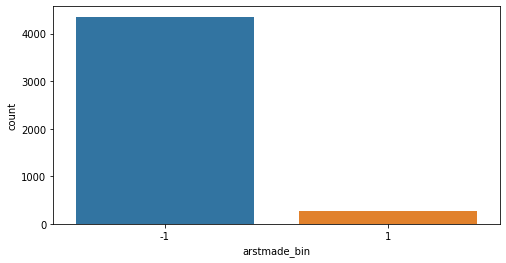

In [26]:
# analizamos el vector objetivo para un arresto
plt.figure(figsize=(8,4))
print(train_df_final['arstmade_bin'].value_counts('%'))
sns.countplot(train_df_final['arstmade_bin'])

__Comentario:__ Podemos ver que nuevamente un poco más de 6% de las detenciones terminan en un arresto.

-1    0.754961
 1    0.245039
Name: act_violenta_bin, dtype: float64


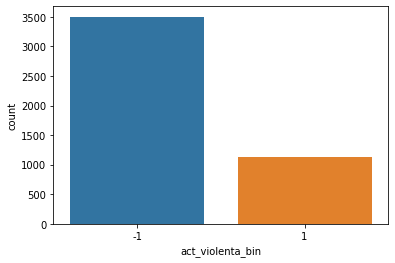

In [27]:
# Revisamos el vector objetivo para una accion violenta
print(train_df_final['act_violenta_bin'].value_counts('%'))
sns.countplot(train_df_final['act_violenta_bin'])

__Comentario:__ Podemos ver que casi un 25% de las detenciones tienen al menos una acción violenta.

## Modelación

### Conjuntos de entrenamiento y prueba

Para entrenar los modelos, determinamos los conjuntos de entrenamiento para ambos vectores con la funcion `get_train_dataset`.

In [28]:
X_train1, y_train1 = prep.get_train_dataset(train_df_final, 'arstmade_bin')

X_test1, y_test1 = prep.get_train_dataset(test_df_final, 'arstmade_bin')

X_train2, y_train2 = prep.get_train_dataset(train_df_final, 'act_violenta_bin')

X_test2, y_test2 = prep.get_train_dataset(test_df_final, 'act_violenta_bin')

In [29]:
# compruebo la estructura de los conjuntos de entrenamiento y validación de cada objetivo
# para el arresto
print(X_train1.shape, X_test1.shape)
print(y_train1.shape, y_test1.shape)
# para determianr una acción violenta
print(X_train2.shape, X_test2.shape)
print(y_train2.shape, y_test2.shape)

(4636, 133) (4747, 133)
(4636, 1) (4747, 1)
(4636, 133) (4747, 133)
(4636, 1) (4747, 1)


### Entrenamiento de modelos para el vector objetivo 1: Procedimiento con Arresto



#### Decision Tree Classifier

In [30]:
# entreno el modelo decisiontreeclassifier sin modificar hiperparámetros
arrest_DTC_model = DecisionTreeClassifier(random_state=rand_seed).fit(X_train1, y_train1)
yhat_arrest_DTC = arrest_DTC_model.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_DTC))

              precision    recall  f1-score   support

          -1       0.97      0.97      0.97      4438
           1       0.58      0.56      0.57       309

    accuracy                           0.94      4747
   macro avg       0.77      0.76      0.77      4747
weighted avg       0.94      0.94      0.94      4747



In [31]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
arrest_DTC_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_seed),
                        {
                            'max_depth':np.linspace(1, 25, 1),
                            'max_features':list(range(1,X_train1.shape[1]))
                        }, cv=5, n_jobs=-1).fit(X_train1, y_train1)
"""

"\narrest_DTC_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_seed),\n                        {\n                            'max_depth':np.linspace(1, 25, 1),\n                            'max_features':list(range(1,X_train1.shape[1]))\n                        }, cv=5, n_jobs=-1).fit(X_train1, y_train1)\n"

In [32]:
# reviso el rendimiento
#arrest_DTC_grid.best_score_

In [33]:
# reviso los mejores parametros
#arrest_DTC_grid.best_params_

In [34]:
#yhat_arrest_DTC = arrest_DTC_grid.best_estimator_.predict(X_test1)
#print(classification_report(y_test1, yhat_arrest_DTC))

In [35]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(arrest_DTC_grid.best_estimator_, open('files/hz_arrest_DTC_model.sav', 'wb'))

In [36]:
# cargo el modelo guardado para utilizarlo
arrest_DTC_serie = pickle.load(open("files/hz_arrest_DTC_model.sav", "rb"))

In [37]:
yhat_arrest_DTC = arrest_DTC_serie.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_DTC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.85      0.58      0.69       309

    accuracy                           0.97      4747
   macro avg       0.91      0.78      0.83      4747
weighted avg       0.96      0.97      0.96      4747



#### C-Support Vector Classification: SVC

In [38]:
# entreno el modelo SVC sin modificar hiperparámetros
arrest_SVC_model = SVC().fit(X_train1, y_train1)
yhat_arrest_SVC = arrest_SVC_model.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_SVC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.82      0.49      0.61       309

    accuracy                           0.96      4747
   macro avg       0.89      0.74      0.79      4747
weighted avg       0.96      0.96      0.95      4747



In [39]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
SVC_c = [1000, 2000, 10000, 100000]
SVC_gamma = [0.000001, 0.00001, 0.0001]
SVC_parameters = {'C':SVC_c, 'gamma':SVC_gamma}
arrest_SVC_grid = GridSearchCV(SVC(kernel='rbf'), 
                               param_grid=SVC_parameters, 
                               cv=5, n_jobs=-1).fit(X_train1, y_train1)
"""

"\nSVC_c = [1000, 2000, 10000, 100000]\nSVC_gamma = [0.000001, 0.00001, 0.0001]\nSVC_parameters = {'C':SVC_c, 'gamma':SVC_gamma}\narrest_SVC_grid = GridSearchCV(SVC(kernel='rbf'), \n                               param_grid=SVC_parameters, \n                               cv=5, n_jobs=-1).fit(X_train1, y_train1)\n"

In [40]:
# reviso el rendimiento
#arrest_SVC_grid.best_score_

In [41]:
# reviso los mejores parámetros
#arrest_SVC_grid.best_params_

In [42]:
#yhat_arrest_SVC = arrest_SVC_grid.best_estimator_.predict(X_test1)
#print(classification_report(y_test1, yhat_arrest_SVC))

In [43]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(arrest_SVC_grid.best_estimator_, open('files/hz_arrest_SVC_model.sav', 'wb'))

In [44]:
# cargo el modelo guardado para utilizarlo
arrest_SVC_serie = pickle.load(open("files/hz_arrest_SVC_model.sav", "rb"))

In [45]:
yhat_arrest_SVC = arrest_SVC_serie.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_SVC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.87      0.59      0.70       309

    accuracy                           0.97      4747
   macro avg       0.92      0.79      0.84      4747
weighted avg       0.97      0.97      0.96      4747



#### Random Forest Classifier

In [46]:
# entreno el modelo randomforestclassifier
arrest_RFC_model = RandomForestClassifier(random_state=rand_seed).fit(X_train1, y_train1)
yhat_arrest_RFC = arrest_RFC_model.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_RFC))

              precision    recall  f1-score   support

          -1       0.96      0.99      0.98      4438
           1       0.83      0.47      0.60       309

    accuracy                           0.96      4747
   macro avg       0.90      0.73      0.79      4747
weighted avg       0.96      0.96      0.95      4747



In [47]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
RFC_max_features = [None, 'log2', 'sqrt']
RFC_n_estimators = range(700, 800, 10)
RFC_max_depth = [1, 5, 10]
RFC_param = {'max_features':RFC_max_features,
             'n_estimators':RFC_n_estimators,
             'max_depth':RFC_max_depth}
arrest_RFC_grid = GridSearchCV(RandomForestClassifier(random_state=rand_seed),
                               param_grid=RFC_param, 
                               cv=5, n_jobs=-1).fit(X_train1, y_train1)
"""

"\nRFC_max_features = [None, 'log2', 'sqrt']\nRFC_n_estimators = range(700, 800, 10)\nRFC_max_depth = [1, 5, 10]\nRFC_param = {'max_features':RFC_max_features,\n             'n_estimators':RFC_n_estimators,\n             'max_depth':RFC_max_depth}\narrest_RFC_grid = GridSearchCV(RandomForestClassifier(random_state=rand_seed),\n                               param_grid=RFC_param, \n                               cv=5, n_jobs=-1).fit(X_train1, y_train1)\n"

In [48]:
# reviso el rendimiento
#arrest_RFC_grid.best_score_

In [49]:
# reviso los mejores parámetros
#arrest_RFC_grid.best_params_

In [50]:
# reviso el reporte de clasificación
#yhat_arrest_RFC = arrest_RFC_grid.best_estimator_.predict(X_test1)
#print(classification_report(y_test1, yhat_arrest_RFC))

In [51]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(arrest_RFC_grid.best_estimator_, open('files/hz_arrest_RFC_model.sav', 'wb'))

In [52]:
# cargo el modelo guardado para utilizarlo
arrest_RFC_serie = pickle.load(open("files/hz_arrest_RFC_model.sav", "rb"))
yhat_arrest_SVC = arrest_RFC_serie.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_SVC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.84      0.56      0.68       309

    accuracy                           0.96      4747
   macro avg       0.91      0.78      0.83      4747
weighted avg       0.96      0.96      0.96      4747



#### Gradient Boosting Classifier

In [53]:
# entreno el modelo GradientBoostingClassifier
arrest_GBC_model = GradientBoostingClassifier(random_state=rand_seed).fit(X_train1, y_train1)
yhat_arrest_GBC = arrest_GBC_model.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_GBC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.84      0.58      0.69       309

    accuracy                           0.97      4747
   macro avg       0.90      0.79      0.83      4747
weighted avg       0.96      0.97      0.96      4747



In [54]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
GBC_param = {'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators': [450, 500, 550], 
             'subsample': [0.93, 0.95, 0.97]}
arrest_GBC_grid = GridSearchCV(GradientBoostingClassifier(random_state=rand_seed), 
                               param_grid=GBC_param, 
                               cv=5, n_jobs=-1).fit(X_train1, y_train1)
"""

"\nGBC_param = {'learning_rate': [0.001, 0.01, 0.1],\n             'n_estimators': [450, 500, 550], \n             'subsample': [0.93, 0.95, 0.97]}\narrest_GBC_grid = GridSearchCV(GradientBoostingClassifier(random_state=rand_seed), \n                               param_grid=GBC_param, \n                               cv=5, n_jobs=-1).fit(X_train1, y_train1)\n"

In [55]:
# reviso el mejor rendimiento
#arrest_GBC_grid.best_score_

In [56]:
# reviso la mejor combinación de hiperparámetros
#arrest_GBC_grid.best_params_

In [57]:
# reporto las métricas de desempeño con la mejor combianción de hiperparámetros
#yhat_arrest_GBC = arrest_GBC_grid.best_estimator_.predict(X_test1)
#print(classification_report(y_test1, yhat_arrest_GBC))

In [58]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(arrest_GBC_grid.best_estimator_, open('files/hz_arrest_GBC_model.sav', 'wb'))

In [59]:
# cargo el modelo guardado para utilizarlo
arrest_GBC_serie = pickle.load(open("files/hz_arrest_GBC_model.sav", "rb"))
yhat_arrest_GBC = arrest_GBC_serie.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_GBC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.83      0.58      0.68       309

    accuracy                           0.96      4747
   macro avg       0.90      0.78      0.83      4747
weighted avg       0.96      0.96      0.96      4747



#### AdaBoost Classifier

In [60]:
# entreno el modelo AdaBoostClassifier
arrest_ABC_model = AdaBoostClassifier(random_state=rand_seed).fit(X_train1, y_train1)
yhat_arrest_ABC = arrest_ABC_model.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_ABC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.81      0.59      0.68       309

    accuracy                           0.96      4747
   macro avg       0.89      0.79      0.83      4747
weighted avg       0.96      0.96      0.96      4747



In [61]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
ABC_param = {'learning_rate': [0.05, 0.1, 0.9],
             'n_estimators': [1000, 2000, 10000]}
arrest_ABC_grid = GridSearchCV(AdaBoostClassifier(random_state=rand_seed),
                               param_grid=ABC_param, 
                               cv=5, n_jobs=-1).fit(X_train1, y_train1)
"""

"\nABC_param = {'learning_rate': [0.05, 0.1, 0.9],\n             'n_estimators': [1000, 2000, 10000]}\narrest_ABC_grid = GridSearchCV(AdaBoostClassifier(random_state=rand_seed),\n                               param_grid=ABC_param, \n                               cv=5, n_jobs=-1).fit(X_train1, y_train1)\n"

In [62]:
# reviso el mejor rendimiento
#arrest_ABC_grid.best_score_

In [63]:
# reviso la mejor combinación de hiperparámetros
#arrest_ABC_grid.best_params_

In [64]:
# reporto las métricas de desempeño con la mejor combianción de hiperparámetros
#yhat_arrest_ABC = arrest_ABC_grid.best_estimator_.predict(X_test1)
#print(classification_report(y_test1, yhat_arrest_ABC))

In [65]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(arrest_ABC_grid.best_estimator_, open('files/hz_arrest_ABC_model.sav', 'wb'))

In [66]:
# cargo el modelo guardado para utilizarlo
arrest_ABC_serie = pickle.load(open("files/hz_arrest_ABC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_arrest_ABC = arrest_ABC_serie.predict(X_test1)
print(classification_report(y_test1, yhat_arrest_ABC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.83      0.57      0.67       309

    accuracy                           0.96      4747
   macro avg       0.90      0.78      0.83      4747
weighted avg       0.96      0.96      0.96      4747



### Elección del mejor modelo para determinar un arresto

Ahora compararemos los resultados de los modelos

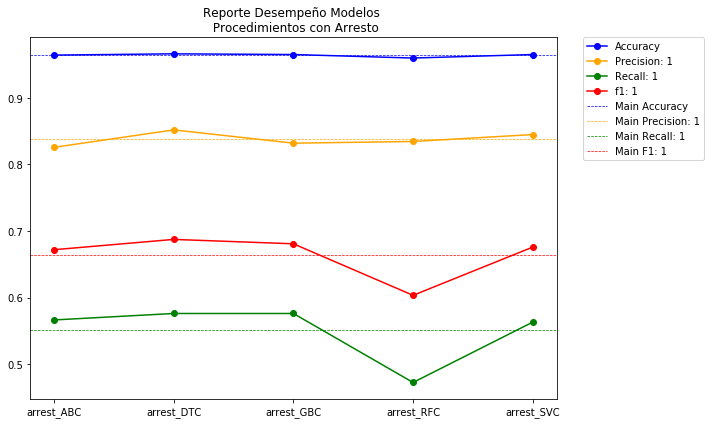

In [67]:
# hago una lista con los modelos
model_list = ['arrest_ABC', 'arrest_DTC', 'arrest_GBC', 'arrest_RFC', 'arrest_SVC']
# hago otra lista con los
yhat_list = [yhat_arrest_ABC, yhat_arrest_DTC, yhat_arrest_GBC, yhat_arrest_RFC, yhat_arrest_SVC]

prep.plot_final_report(model_list, yhat_list, y_test1)

__Comentario:__ Dado los resultados nos quedaremos con el modelo `arrest_DTC` (Decision Tree Classifier).

#### Importancia Atributos

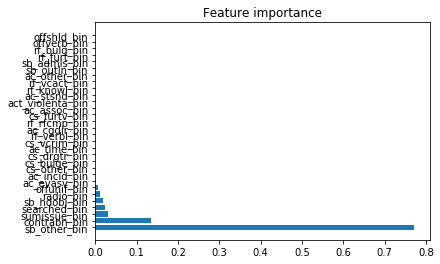

In [68]:
tmp_df_import = prep.plot_importance(arrest_DTC_serie, list(X_test1.columns), 30)

In [69]:
# reentreno el modelo con los 7 parámetros con mayor importancia
tmp_df_import = tmp_df_import.head(30)
tmp_imp = list(tmp_df_import.index)

In [71]:
X_tr, y_tr = prep.get_train_dataset(train_df_final.loc[:,tmp_imp+['arstmade_bin']], 'arstmade_bin')
X_ts, y_ts = prep.get_train_dataset(test_df_final.loc[:,tmp_imp+['arstmade_bin']], 'arstmade_bin')

In [72]:
arrest_DTC = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3.0,
                       max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=16254, splitter='best').fit(X_tr, y_tr)

In [73]:
yhat_DTC = arrest_DTC.predict(X_ts)
print(classification_report(y_ts, yhat_DTC))

              precision    recall  f1-score   support

          -1       0.97      0.99      0.98      4438
           1       0.85      0.58      0.69       309

    accuracy                           0.97      4747
   macro avg       0.91      0.78      0.83      4747
weighted avg       0.96      0.97      0.96      4747



__Comentarios:__ Al refactorizar el modelo con los atributos de mayor importancia los resultados son casi los mismos. Esto se debe a que la cantidad de atributos de importancia es muy pequeña, inferior a los 30 atributos utilizados.

#### Probabilidad de arresto

Se reporta la probabilidad que un individuo sea arrestado en uno de los cinco barrios, condicional al género y condicional a la raza.

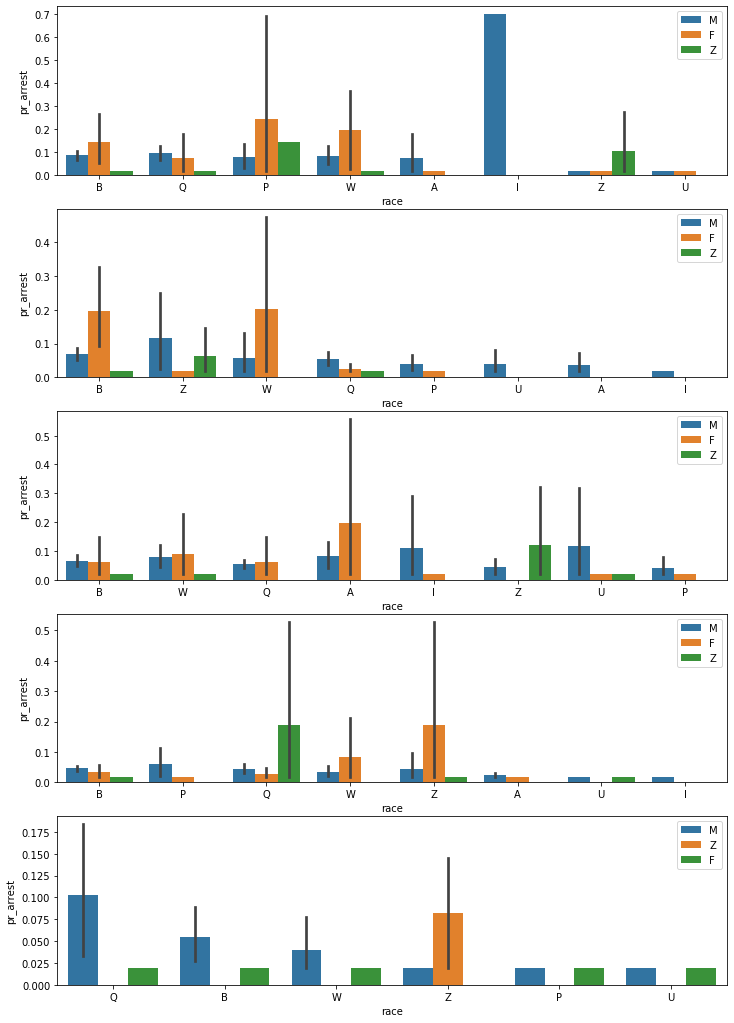

<Figure size 432x288 with 0 Axes>

In [74]:
pr_arrest = arrest_DTC.predict_proba(X_ts)
pr_df = test_df_st.loc[:,['city','race', 'sex','arstmade']]
pr_df['pr_no_arrest'] = pr_arrest[:,0]
pr_df['pr_arrest'] = pr_arrest[:,1]

city_list = list(pr_df['city'].unique())

plt.figure(figsize=(12,18))
plt.title('Probabilidad de Arrestos')
for i, city in enumerate(city_list):
    tmp_df = pr_df[pr_df['city']==city]
    #var = tmp_df['pr_arrest'].sort_values()
    plt.subplot(len(city_list),1, i+1)
    #plt.plot(var, list(var.index), 'o', color='orange')
    sns.barplot(data=tmp_df.sort_values(by='pr_arrest', ascending=False), x='race', y='pr_arrest', hue='sex')
    plt.legend(loc='upper right')
plt.show()
plt.tight_layout()

### Entrenamiento de modelos para el vector objetivo 2: Detención con accion violenta

#### Decision Tree Classifier

In [75]:
# entreno el modelo decisiontreeclassifier
act_violenta_DTC_model = DecisionTreeClassifier(random_state=rand_seed).fit(X_train2, y_train2)
yhat_act_violenta_DTC = act_violenta_DTC_model.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_DTC))

              precision    recall  f1-score   support

          -1       0.82      0.80      0.81      3639
           1       0.40      0.44      0.42      1108

    accuracy                           0.71      4747
   macro avg       0.61      0.62      0.61      4747
weighted avg       0.72      0.71      0.72      4747



In [76]:
# genero el gridsearch con la combinacion de hiperparametros
"""
act_violenta_DTC_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_seed),
                                     {
                                         'max_depth':np.linspace(1, 10, 20),
                                         'max_features':list(range(1,X_train2.shape[1]))
                                     }, cv=5, n_jobs=-1).fit(X_train2, y_train2)
"""

"\nact_violenta_DTC_grid = GridSearchCV(DecisionTreeClassifier(random_state=rand_seed),\n                                     {\n                                         'max_depth':np.linspace(1, 10, 20),\n                                         'max_features':list(range(1,X_train2.shape[1]))\n                                     }, cv=5, n_jobs=-1).fit(X_train2, y_train2)\n"

In [77]:
# reviso el mejor score
#act_violenta_DTC_grid.best_score_

In [78]:
# reviso la mejor combinación de parámetros
#act_violenta_DTC_grid.best_params_

In [79]:
# reporto las métricas de clasificación
#yhat_act_violenta_DTC = act_violenta_DTC_grid.best_estimator_.predict(X_test2)
#print(classification_report(y_test2, yhat_act_violenta_DTC))

In [80]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(act_violenta_DTC_grid.best_estimator_, open('files/hz_act_violenta_DTC_model.sav', 'wb'))

In [81]:
# cargo el modelo guardado para utilizarlo
act_violenta_DTC_serie = pickle.load(open("files/hz_act_violenta_DTC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_act_violenta_DTC = act_violenta_DTC_serie.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_DTC))

              precision    recall  f1-score   support

          -1       0.79      0.96      0.87      3639
           1       0.57      0.15      0.24      1108

    accuracy                           0.77      4747
   macro avg       0.68      0.56      0.55      4747
weighted avg       0.74      0.77      0.72      4747



#### C-Support Vector Classification: SVC

In [82]:
# entreno el modelo SVC
act_violenta_SVC_model = SVC().fit(X_train2, y_train2)
yhat_act_violenta_SVC = act_violenta_SVC_model.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_SVC))

              precision    recall  f1-score   support

          -1       0.78      0.98      0.87      3639
           1       0.63      0.10      0.17      1108

    accuracy                           0.78      4747
   macro avg       0.71      0.54      0.52      4747
weighted avg       0.75      0.78      0.71      4747



In [83]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
SVC_c = [15000, 20000, 50000]
SVC_gamma = [0.0001, 0.0005, 0.0009]
SVC_parameters = {'C':SVC_c, 'gamma':SVC_gamma}
act_violenta_SVC_grid = GridSearchCV(SVC(kernel='rbf'), 
                               param_grid=SVC_parameters, 
                               cv=5, n_jobs=-1).fit(X_train2, y_train2)
"""

"\nSVC_c = [15000, 20000, 50000]\nSVC_gamma = [0.0001, 0.0005, 0.0009]\nSVC_parameters = {'C':SVC_c, 'gamma':SVC_gamma}\nact_violenta_SVC_grid = GridSearchCV(SVC(kernel='rbf'), \n                               param_grid=SVC_parameters, \n                               cv=5, n_jobs=-1).fit(X_train2, y_train2)\n"

In [84]:
# reviso el mejor score
#act_violenta_SVC_grid.best_score_

In [85]:
# reviso la mejor combinacion de parametros
#act_violenta_SVC_grid.best_params_

In [86]:
# revisamos las metricas de desempeño
#yhat_act_violenta_SVC = act_violenta_SVC_grid.best_estimator_.predict(X_test2)
#print(classification_report(y_test2, yhat_act_violenta_SVC))

In [87]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(act_violenta_SVC_grid.best_estimator_, open('files/hz_act_violenta_SVC_model.sav', 'wb'))
# cargo el modelo guardado para utilizarlo
act_violenta_SVC_serie = pickle.load(open("files/hz_act_violenta_SVC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_act_violenta_DTC = act_violenta_SVC_serie.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_DTC))

              precision    recall  f1-score   support

          -1       0.78      0.98      0.87      3639
           1       0.60      0.10      0.17      1108

    accuracy                           0.77      4747
   macro avg       0.69      0.54      0.52      4747
weighted avg       0.74      0.77      0.71      4747



#### Random Forest Classifier

In [88]:
# entreno el modelo randomforestclassifier
act_violenta_RFC_model = RandomForestClassifier(random_state=rand_seed).fit(X_train2, y_train2)
yhat_act_violenta_RFC = act_violenta_RFC_model.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_RFC))

              precision    recall  f1-score   support

          -1       0.80      0.93      0.86      3639
           1       0.49      0.23      0.31      1108

    accuracy                           0.76      4747
   macro avg       0.64      0.58      0.59      4747
weighted avg       0.73      0.76      0.73      4747



In [89]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
RFC_max_features = [None, 'log2', 'sqrt']
RFC_n_estimators = range(1, 100, 10)
RFC_max_depth = [1, 5, 10]
RFC_param = {'max_features':RFC_max_features,
             'n_estimators':RFC_n_estimators,
             'max_depth':RFC_max_depth}
act_violenta_RFC_grid = GridSearchCV(RandomForestClassifier(random_state=rand_seed),
                               param_grid=RFC_param, 
                               cv=5, n_jobs=-1).fit(X_train2, y_train2)
"""

"\nRFC_max_features = [None, 'log2', 'sqrt']\nRFC_n_estimators = range(1, 100, 10)\nRFC_max_depth = [1, 5, 10]\nRFC_param = {'max_features':RFC_max_features,\n             'n_estimators':RFC_n_estimators,\n             'max_depth':RFC_max_depth}\nact_violenta_RFC_grid = GridSearchCV(RandomForestClassifier(random_state=rand_seed),\n                               param_grid=RFC_param, \n                               cv=5, n_jobs=-1).fit(X_train2, y_train2)\n"

In [90]:
# reviso el mejor score
#act_violenta_RFC_grid.best_score_

In [91]:
# reviso la mejor combinacion de parametros
#act_violenta_RFC_grid.best_params_

In [92]:
# reviso las metricas de desempeño
#yhat_act_violenta_RFC = act_violenta_RFC_grid.best_estimator_.predict(X_test2)
#print(classification_report(y_test2, yhat_act_violenta_RFC))

In [93]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(act_violenta_RFC_grid.best_estimator_, open('files/hz_act_violenta_RFC_model.sav', 'wb'))
# cargo el modelo guardado para utilizarlo
act_violenta_RFC_serie = pickle.load(open("files/hz_act_violenta_RFC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_act_violenta_RFC = act_violenta_RFC_serie.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_RFC))

              precision    recall  f1-score   support

          -1       0.78      0.98      0.87      3639
           1       0.60      0.10      0.17      1108

    accuracy                           0.77      4747
   macro avg       0.69      0.54      0.52      4747
weighted avg       0.74      0.77      0.71      4747



#### Gradient Boosting Classifier

In [94]:
# entreno el modelo GradientBoostingClassifier
act_violenta_GBC_model = GradientBoostingClassifier(random_state=rand_seed).fit(X_train2, y_train2)
yhat_act_violenta_GBC = act_violenta_GBC_model.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_GBC))

              precision    recall  f1-score   support

          -1       0.80      0.94      0.86      3639
           1       0.52      0.22      0.31      1108

    accuracy                           0.77      4747
   macro avg       0.66      0.58      0.58      4747
weighted avg       0.73      0.77      0.73      4747



In [95]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
GBC_param = {'learning_rate': [0.001, 0.01, 0.1],
             'n_estimators': [10, 100, 1000, 10000], 
             'subsample': [0.01, 0.4, 1]}
act_violenta_GBC_grid = GridSearchCV(GradientBoostingClassifier(random_state=rand_seed), 
                                     param_grid=GBC_param, 
                                     cv=5, n_jobs=-1).fit(X_train2, y_train2)
"""

"\nGBC_param = {'learning_rate': [0.001, 0.01, 0.1],\n             'n_estimators': [10, 100, 1000, 10000], \n             'subsample': [0.01, 0.4, 1]}\nact_violenta_GBC_grid = GridSearchCV(GradientBoostingClassifier(random_state=rand_seed), \n                                     param_grid=GBC_param, \n                                     cv=5, n_jobs=-1).fit(X_train2, y_train2)\n"

In [96]:
# reviso el mejor score
#act_violenta_GBC_grid.best_score_

In [97]:
# reviso la mejor combinacion de hiperparámetros
#act_violenta_GBC_grid.best_params_

In [98]:
# revisamos las metricas de desempeño
#yhat_act_violenta_GBC = act_violenta_GBC_grid.best_estimator_.predict(X_test2)
#print(classification_report(y_test2, yhat_act_violenta_GBC))

In [101]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(act_violenta_GBC_grid.best_estimator_, open('files/hz_act_violenta_GBC_model.sav', 'wb'))
# cargo el modelo guardado para utilizarlo
act_violenta_GBC_serie = pickle.load(open("files/hz_act_violenta_GBC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_act_violenta_GBC = act_violenta_GBC_serie.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_GBC))

              precision    recall  f1-score   support

          -1       0.81      0.93      0.86      3639
           1       0.54      0.27      0.36      1108

    accuracy                           0.78      4747
   macro avg       0.67      0.60      0.61      4747
weighted avg       0.75      0.78      0.75      4747



#### AdaBoost Classifier

In [102]:
# entreno del modelo AdaBoostClassifier
act_violenta_ABC_model = AdaBoostClassifier(random_state=rand_seed).fit(X_train2, y_train2)
yhat_act_violenta_ABC = act_violenta_ABC_model.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_ABC))

              precision    recall  f1-score   support

          -1       0.81      0.90      0.85      3639
           1       0.49      0.32      0.39      1108

    accuracy                           0.76      4747
   macro avg       0.65      0.61      0.62      4747
weighted avg       0.74      0.76      0.75      4747



In [103]:
# para mejorar el desempeño del modelo, genero una grilla con hiperparámetros 
"""
ABC_param = {'learning_rate': [0.005, 0.01, 0.05],
             'n_estimators': [1, 50, 1000]}
act_violenta_ABC_grid = GridSearchCV(AdaBoostClassifier(random_state=rand_seed),
                                     param_grid=ABC_param, 
                                     cv=5, n_jobs=-1).fit(X_train2, y_train2)
"""

"\nABC_param = {'learning_rate': [0.005, 0.01, 0.05],\n             'n_estimators': [1, 50, 1000]}\nact_violenta_ABC_grid = GridSearchCV(AdaBoostClassifier(random_state=rand_seed),\n                                     param_grid=ABC_param, \n                                     cv=5, n_jobs=-1).fit(X_train2, y_train2)\n"

In [104]:
# reviso el mejor score
#act_violenta_ABC_grid.best_score_

In [105]:
# reviso la mejor combinación de hiperparámetros
#act_violenta_ABC_grid.best_params_

In [106]:
# reviso las metricas de desempeño
#yhat_act_violenta_ABC = act_violenta_ABC_grid.best_estimator_.predict(X_test2)
#print(classification_report(y_test2, yhat_act_violenta_ABC))

In [107]:
# guardo el modelo para no volver a entrenarlo
#pickle.dump(act_violenta_ABC_grid.best_estimator_, open('files/hz_act_violenta_ABC_model.sav', 'wb'))
# cargo el modelo guardado para utilizarlo
act_violenta_ABC_serie = pickle.load(open("files/hz_act_violenta_ABC_model.sav", "rb"))
# reporto las métricas de clasificación
yhat_act_violenta_ABC = act_violenta_ABC_serie.predict(X_test2)
print(classification_report(y_test2, yhat_act_violenta_ABC))

              precision    recall  f1-score   support

          -1       0.79      0.97      0.87      3639
           1       0.55      0.14      0.22      1108

    accuracy                           0.77      4747
   macro avg       0.67      0.55      0.54      4747
weighted avg       0.73      0.77      0.72      4747



#### Elección del mejor modelo para una acción violenta

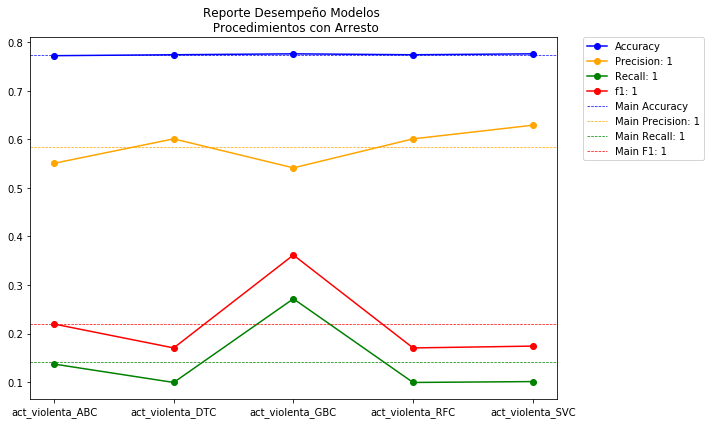

In [108]:
# hago una lista con los modelos
model_list = ['act_violenta_ABC', 'act_violenta_DTC', 'act_violenta_GBC', 'act_violenta_RFC', 'act_violenta_SVC']
# hago otra lista con los
yhat_list = [yhat_act_violenta_ABC, yhat_act_violenta_DTC, yhat_act_violenta_GBC, yhat_act_violenta_RFC, yhat_act_violenta_SVC]

prep.plot_final_report(model_list, yhat_list, y_test2)

__Comentario:__ En este caso nos quedaremos con los modelos `act_violent_SVC` y `act_violent_RFC` considerando que tiene mejor `Precision` que el resto.